In [1]:
from qcportal import PortalClient
from qcelemental.models.results import WavefunctionProtocolEnum
from openff.qcsubmit.results import OptimizationResultCollection,BasicResultCollection
from openff.qcsubmit.datasets import OptimizationDataset
from openff.qcsubmit.factories import OptimizationDatasetFactory
from openff.qcsubmit.common_structures import Metadata, QCSpec
import numpy as np
from openff.toolkit import Molecule
import tqdm
from openff.toolkit.utils import OpenEyeToolkitWrapper, ToolkitRegistry
from openff.units import unit
from openeye import oechem
import itertools
import multiprocess

In [2]:
client = PortalClient("https://api.qcarchive.molssi.org:443/")

# Generate conformers (for all molecules in the dataset)

The initial dataset can be downloaded from the server or read in from `mlpepper.json.bz2` after unzipping it with `bzip2 -d mlpepper.json.bz2`

In [3]:
# mlpepper_results = BasicResultCollection.from_server(client=client, datasets=['MLPepper RECAP Optimized Fragments v1.0','MLPepper RECAP Optimized Fragments v1.0 Add Iodines'],spec_name='wb97x-d/def2-tzvpp')

In [4]:
mlpepper_results = BasicResultCollection.parse_file('mlpepper.json')

In [5]:
mlpepper_results.n_molecules

56346

In [6]:
mlpepper_cmiles = np.unique([result.cmiles for result in mlpepper_results.entries['https://api.qcarchive.molssi.org:443/']])

In [7]:
def generate_conformers_pool(inputs) -> Molecule:
    '''
    Function to generate conformers from a CMILES string. Taken from Lily's NAGL2 code.

    inputs should be a list of:
    cmiles: CMILES string to use
    max_conf_elf: maximum number of conformers to keep during the ELF process 
    elf_perc: Percentage of conformers to select from for the ELF process
    n_conf_start: initial number of conformers to generate, to use later for ELF selection
    rms_cut: RMS cutoff for conformer generation
    '''
    # OE logging
    errfs = oechem.oeofstream("openeye_log.txt")
    if not errfs:
        oechem.OEThrow.Fatal("Unable to create %s" % fname)
    oechem.OEThrow.SetOutputStream(errfs)
    oechem.OEThrow.SetLevel(oechem.OEErrorLevel_MIN)
    
    cmiles, max_conf_elf, elf_perc, n_conf_start, rms_cut=inputs
    wrapper = OpenEyeToolkitWrapper()
    
    try:
        mol = Molecule.from_mapped_smiles(
            cmiles,
            allow_undefined_stereo=True,
            toolkit_registry=wrapper,
        )
        # generate max 1000 conformers with OpenEye
        mol.generate_conformers(
            n_conformers=n_conf_start,
            rms_cutoff=rms_cut * unit.angstrom,
            toolkit_registry=wrapper,
        )
        
        # prune based on ELF method, max 5 conformers output
        mol.apply_elf_conformer_selection(
            percentage=elf_perc,
            limit=max_conf_elf,
            toolkit_registry=wrapper
        )
        
        assert mol.n_conformers > 0

        errfs.flush()
        errfs.close()
        return (mol,'success')
    except BaseException as e:
        errfs.flush()
        errfs.close()
        return (mol,e)

In [8]:
mols = []
n_confs = []
errs = []
with multiprocess.Pool(8) as pool:
    for ms in tqdm.tqdm(pool.imap(generate_conformers_pool,zip(mlpepper_cmiles,itertools.repeat(5),itertools.repeat(2),itertools.repeat(1000),itertools.repeat(0.1))), desc="generating conformers",total=len(mlpepper_cmiles)):
        mol = ms[0]
        status = ms[1]
        if status == 'success':
            n_confs.append(mol.n_conformers)
            mols.append(mol)
        else:
            print(status)
            errs.append((mol,status))

generating conformers:  10%|███████▌                                                                        | 5362/56346 [04:32<32:45, 25.95it/s]

OpenEye Omega conformer generation failed
OpenEye Omega conformer generation failed


generating conformers:  16%|████████████▍                                                                   | 8777/56346 [07:49<33:02, 24.00it/s]

OpenEye Omega conformer generation failed
OpenEye Omega conformer generation failed


generating conformers:  29%|██████████████████████▌                                                        | 16081/56346 [14:55<26:06, 25.71it/s]

OpenEye Omega conformer generation failed


generating conformers:  34%|███████████████████████████▏                                                   | 19363/56346 [18:35<23:30, 26.21it/s]

OpenEye Omega conformer generation failed


generating conformers:  42%|█████████████████████████████████▏                                             | 23636/56346 [22:14<19:02, 28.64it/s]

OpenEye Omega conformer generation failed


generating conformers:  62%|████████████████████████████████████████████████▌                              | 34679/56346 [31:46<15:05, 23.93it/s]

OpenEye Omega conformer generation failed


generating conformers:  67%|████████████████████████████████████████████████████▉                          | 37754/56346 [35:18<08:58, 34.55it/s]

OpenEye Omega conformer generation failed


generating conformers:  84%|██████████████████████████████████████████████████████████████████▎            | 47270/56346 [48:17<19:58,  7.58it/s]

OpenEye Omega conformer generation failed


generating conformers:  84%|██████████████████████████████████████████████████████████████████▎            | 47335/56346 [48:25<21:30,  6.98it/s]

OpenEye Omega conformer generation failed


generating conformers:  84%|██████████████████████████████████████████████████████████████████▌            | 47519/56346 [49:00<50:50,  2.89it/s]

OpenEye Omega conformer generation failed


generating conformers:  84%|██████████████████████████████████████████████████████████████████▋            | 47603/56346 [49:08<04:32, 32.07it/s]

OpenEye Omega conformer generation failed
OpenEye Omega conformer generation failed


generating conformers: 100%|███████████████████████████████████████████████████████████████████████████████| 56346/56346 [56:00<00:00, 16.77it/s]


## Analyze conformer distribution (for the whole dataset)

In [17]:
print(min(n_confs),np.mean(n_confs),np.median(n_confs),max(n_confs))

1 2.3700205922033657 1.0 5


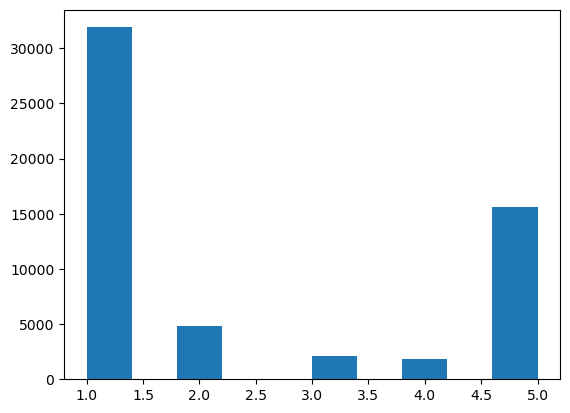

In [18]:
from matplotlib import pyplot as plt
plt.figure()
plt.hist(n_confs)
plt.show()

In [19]:
len(errs)

14

In [20]:
all_masses = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in mols
])

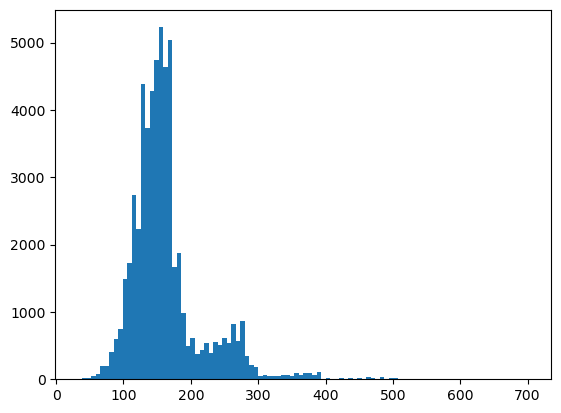

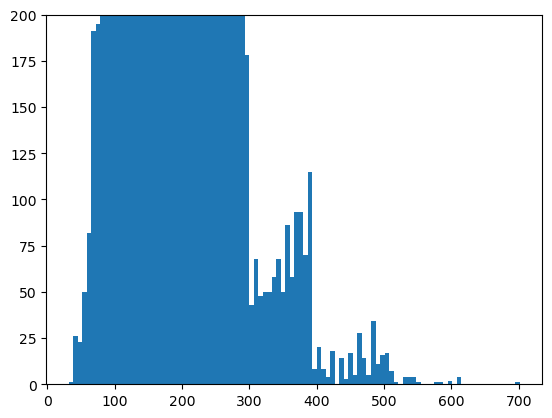

In [21]:
plt.figure()
plt.hist(all_masses,bins=100)

plt.figure()
plt.hist(all_masses,bins=100)
plt.ylim(0,200)
plt.show()

In [22]:
print(min(all_masses),np.mean(all_masses),np.median(all_masses),max(all_masses))

32.117318 163.19101083271855 153.202739 701.588756


We could split this up into < 200 Da, 200-300 Da, and > 300 Da. Or <200, 200-400, >400. Let's try our original suggestion of < 300 and > 300.

In [23]:
mols_part1 = []
mols_part2 = []
for mol in tqdm.tqdm(mols):
    if sum([atom.mass.m for atom in mol.atoms]) <= 300:
        mols_part1.append(mol)
    else:
        mols_part2.append(mol)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 56332/56332 [00:00<00:00, 143737.75it/s]


# Create dataset

## Part 1-- Molecules less than 300 Da

In [24]:
dataset_factory1 = OptimizationDatasetFactory()
provenance1 = dataset_factory1.provenance(ToolkitRegistry([OpenEyeToolkitWrapper]))

In [26]:
dataset1 = dataset_factory1.create_dataset(
    dataset_name="OpenFF NAGL2 Training Optimization Dataset Part 1 v4.0",
    tagline="B3LYP-D3BJ/DZVP conformers of diverse fragment molecules with molecular weight less than 300 Da.",
    description=(
        "A dataset containing molecules from the "
        "`MLPepper RECAP Optimized Fragments v1.0` and `MLPepper RECAP Optimized Fragments v1.0 Add Iodines` "
        "with new conformers and optimized at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). "
        "The dataset is intended to be used for calculating single point energies and properties, "
        "which will then be used to train our second-generation graph neural network charge model (NAGL2)."
        "This is part 1, for molecules with molecular weight less than 300 Da.\n\n"
        "For each molecule, a set of up to 5 conformers were generated by:\n"
        "  * generating a set of up to 1000 conformers with a RMS cutoff of 0.1 Å "
        "using the OpenEye backend of the OpenFF toolkit\n"
        "  * applying ELF conformer selection (max 5 conformers) using OpenEye\n\n"
        "Each conformer will be converged according to the 'GAU_LOOSE' criteria."
    ),
    molecules=mols_part1
)
dataset1.metadata.submitter = "amcisaac"
dataset1.metadata.long_description_url = (
        "https://github.com/openforcefield/qca-dataset-submission/tree/master/"
        "submissions/"
        "2024-11-19-OpenFF-NAGL2-Training-Optimization-Dataset-Part-1-v4.0"
    )

Preparation                   : 100%|█████| 55134/55134 [21:43<00:00, 42.29it/s]


## Dataset info

In [28]:
dataset1._get_specifications()

{'default': OptimizationSpecification(program='geometric', qc_specification=QCSpecification(program='psi4', driver=<SinglepointDriver.deferred: 'deferred'>, method='b3lyp-d3bj', basis='dzvp', keywords={'maxiter': 200, 'scf_properties': [<SCFProperties.Dipole: 'dipole'>, <SCFProperties.Quadrupole: 'quadrupole'>, <SCFProperties.WibergLowdinIndices: 'wiberg_lowdin_indices'>, <SCFProperties.MayerIndices: 'mayer_indices'>]}, protocols=AtomicResultProtocols(wavefunction=<WavefunctionProtocolEnum.none: 'none'>, stdout=True, error_correction=ErrorCorrectionProtocol(default_policy=True, policies=None), native_files=<NativeFilesProtocolEnum.none: 'none'>)), keywords={'coordsys': 'dlc', 'enforce': 0.0, 'epsilon': 1e-05, 'reset': True, 'qccnv': False, 'molcnv': False, 'check': 0, 'trust': 0.1, 'tmax': 0.3, 'maxiter': 300, 'convergence_set': 'GAU'}, protocols=OptimizationProtocols(trajectory=<TrajectoryProtocolEnum.all: 'all'>))}

In [31]:
n_confs1 = np.array(
    [mol.n_conformers for mol in dataset1.molecules]
)

n_heavy_atoms1 = np.array(
    [mol.to_rdkit().GetNumHeavyAtoms() for mol in dataset1.molecules]
)

masses1 = np.array([
    sum([atom.mass.m for atom in mol.atoms])
    for mol in dataset1.molecules
])

elements1 = set(
    atom.symbol
    for mol in dataset1.molecules
    for atom in mol.atoms
)

In [32]:
unique_charges1 = [str(charge) for charge in sorted(set([
    mol.total_charge.m_as(unit.elementary_charge)
    for mol in dataset1.molecules
]))]

In [33]:
unique_charges1

['-4.0', '-3.0', '-2.0', '-1.0', '0.0', '1.0', '2.0', '3.0']

In [34]:
from collections import Counter

print("# heavy atoms")
counts1 = Counter(n_heavy_atoms1)
for n_heavy in sorted(counts1):
    print(f"{str(n_heavy):>3}: {counts1[n_heavy]}")

# heavy atoms
  1: 1
  2: 2
  3: 71
  4: 196
  5: 553
  6: 1318
  7: 2918
  8: 5645
  9: 8456
 10: 10653
 11: 12403
 12: 12286
 13: 52
 14: 96
 15: 61
 16: 77
 17: 124
 18: 107
 19: 70
 20: 44
 21: 1


In [35]:
print('* Name: {}'.format(dataset1.dataset_name))
print('* Number of unique molecules: {}'.format(dataset1.n_molecules))
print('* Number of conformers: {}'.format(dataset1.n_records))
print('* Number of conformers (min, mean, max): {:.2f}, {:.2f}, {:.2f}'.format(min(n_confs1),np.mean(n_confs1),max(n_confs1)))
print('* Molecular weight (min, mean, max): {:.2f}, {:.2f}, {:.2f}'.format(min(masses1),np.mean(masses1),max(masses1)))
print('* Charges: {}'.format(' '.join(unique_charges1)))

* Name: OpenFF NAGL2 Training Optimization Dataset Part 1 v4.0
* Number of unique molecules: 55134
* Number of conformers: 131185
* Number of conformers (min, mean, max): 1.00, 2.38, 10.00
* Molecular weight (min, mean, max): 32.12, 158.53, 299.97
* Charges: -4.0 -3.0 -2.0 -1.0 0.0 1.0 2.0 3.0


In [36]:
print("## Metadata")
print(f"* Elements: {{{', '.join(dataset1.metadata.dict()['elements'])}}}")

def print_field(od, field): print(f"  * {field}: {od[field]}")

fields = ["basis", "implicit_solvent", "keywords", "maxiter", "method", "program"]
for spec, obj in dataset1.qc_specifications.items():
    od = obj.dict()
    print("* Spec:", spec)
    for field in fields:
        print_field(od, field)
    print("  * SCF properties:")
    for field in od["scf_properties"]:
        print(f"    * {field}")

## Metadata
* Elements: {C, Cl, I, S, B, O, Br, Si, P, F, N, H}
* Spec: default
  * basis: DZVP
  * implicit_solvent: None
  * keywords: {}
  * maxiter: 200
  * method: B3LYP-D3BJ
  * program: psi4
  * SCF properties:
    * dipole
    * quadrupole
    * wiberg_lowdin_indices
    * mayer_indices


## Exporting dataset

Need to add info like elements and charges etc to comply with standards

In [37]:
dataset1.metadata.long_description=(("A dataset containing molecules from the "
        "`MLPepper RECAP Optimized Fragments v1.0` and `MLPepper RECAP Optimized Fragments v1.0 Add Iodines` "
        "with new conformers and optimized at the OpenFF default level of theory (B3LYP-D3BJ/DZVP). "
        "The dataset is intended to be used for calculating single point energies and properties, "
        "which will then be used to train our second-generation graph neural network charge model (NAGL2)."
        "This is part 1, for molecules with molecular weight less than 300 Da.\n\n"
        "For each molecule, a set of up to 5 conformers were generated by:\n"
        "  * generating a set of up to 1000 conformers with a RMS cutoff of 0.1 Å "
        "using the OpenEye backend of the OpenFF toolkit\n"
        "  * applying ELF conformer selection (max 5 conformers) using OpenEye\n\n"
        "Dataset information:\n"
        "* Number of unique molecules: {}\n"
        "* Number of conformers: {}\n"
        "* Number of conformers (min, mean, max): {:.2f}, {:.2f}, {:.2f}\n"
        "* Molecular weight (min, mean, max): {:.2f}, {:.2f}, {:.2f}\n"
        "* Charges: {}".format(dataset1.n_molecules,dataset1.n_records,min(n_confs1),np.mean(n_confs1),max(n_confs1),min(masses1),np.mean(masses1),max(masses1),' '.join(unique_charges1))
        ))

In [38]:
dataset1.export_dataset("dataset_part1.json.bz2")
dataset1.molecules_to_file('dataset_part1.smi', 'smi')
dataset1.visualize("dataset_part1.pdf", columns=8)

# Save MLPepper dataset for part 2 generation

In [38]:
with open('mlpepper.json','w') as jsonfile:
    jsonfile.write(mlpepper_results.json(indent=2))